# Global Explanations

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import shap

from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

from sklearn import tree

from collections import defaultdict
from IPython.display import HTML

shap.initjs()
np.random.seed(1)

c:\Users\marco\Desktop\Actor\Environments\generalEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Dataset Link
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html


In [2]:
df = pd.read_csv("Data/diabetes_dataset.csv", index_col=0)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [3]:
print('Number of samples: ', df.shape[0])
print('Number of features: ', df.shape[1]) 

Number of samples:  442
Number of features:  11


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  y       442 non-null    float64
dtypes: float64(11)
memory usage: 41.4 KB



Attribute Information:
  - age:  &emsp;    age in years
  - sex:
  - bmi:   &emsp;   body mass index
  - bp:   &emsp;    average blood pressure
  - s1:    &emsp;   tc, total serum cholesterol
  - s2:    &emsp;   ldl, low-density lipoproteins
  - s3:   &emsp;    hdl, high-density lipoproteins
  - s4:    &emsp;   tch, total cholesterol / HDL
  - s5:    &emsp;   ltg, possibly log of serum triglycerides level
  - s6:    &emsp;   glu, blood sugar level

  - y:    &emsp;    is a quantitative measure of disease progression one year after baseline


In [5]:
X,y = df.drop(columns = ['y']), df['y']

In [6]:
print(y.describe())

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: y, dtype: float64


### Decision Tree
<>


<img src="Images/albero_decisione_esempio.png" style="width: 500px; height: 300px;"/>

### Random Forest

<img src="Images/random_forest_immagine.png" style="width: 500px; height: 300px;"/>


# 15 minuti fino a qui

In [7]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)
# train random forest classifier
#model = RandomForestRegressor(n_estimators=50, random_state=8)
model = RandomForestRegressor(n_estimators=100, random_state=8, max_depth = 5, min_samples_leaf=5)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test).reshape(-1,1)
y_pred_train = model.predict(X_train)

print("Mean Absolute Error on the test set: ", MAE(y_test, y_pred_test))
print("Mean Absolute Error on the training set: ", MAE(y_train, y_pred_train))


conc_pred_test = np.concatenate((y_test.values.reshape(-1,1), y_pred_test), axis = 1)
conc_pred_test[:8]


Mean Absolute Error on the test set:  48.64376975922123
Mean Absolute Error on the training set:  33.2373643352521


array([[242.        , 213.13147363],
       [185.        , 125.45847556],
       [202.        , 162.64860462],
       [128.        ,  79.01922769],
       [197.        , 189.2747016 ],
       [150.        , 122.49645875],
       [137.        , 176.47333425],
       [175.        , 196.53426408]])

## Motivating Example:

* The model is extremely difficult to interpret: it is **black-box**
* 5 of the 100 trees in the random forest are shown below - it is very complex!
* But it (allegedly) gives us good predictions...

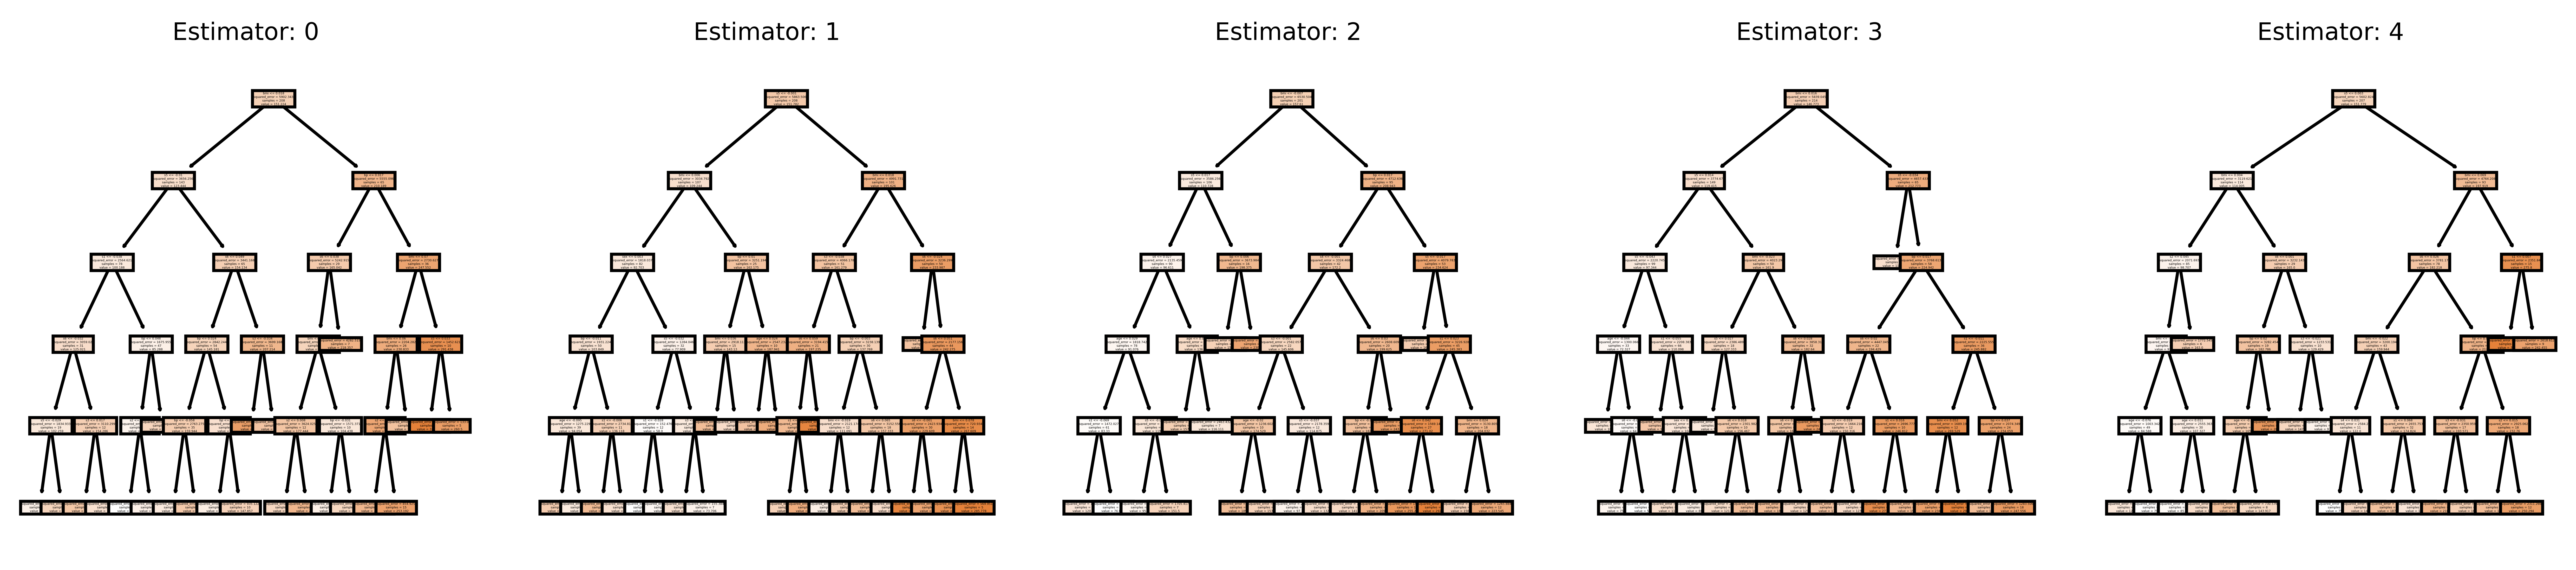

In [8]:
# plot 5 trees from our random forest model
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (15,3), dpi=900)
for index in range(0, 5):
    tree.plot_tree(model.estimators_[index],
                   feature_names = list(X.columns), 
                   #class_names=dataset.target_names,
                   filled = True,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 8)
plt.plot()
plt.show()

# 15 minuti fino a qui

## Overview

We will cover two **feature attribution** global explanation methods:
1. Permutation Feature Importance
    * Intuition and theory
    * Implementation on example
2. SHAP (SHapley Additive exPlanations)
    * Theory of Shapley values
    * Intuition and theory
    * Using SHAP for global and local explanations
    * Example on our dataset

# Permutation Feature Importance

### Idea: 
*what are the features that influence the output of our model most?*

 - take one column(feature) at the time
 - shuffle the values in the column
 - observe how much the model's performance changes. The greater the change, the greater the significance of that column.
 
 - for more details, check this [blog](https://christophm.github.io/interpretable-ml-book/feature-importance.html) and the original [paper](https://arxiv.org/abs/1801.01489) 


<img src="Images/permutation_feature_importance_image2.png" style="width: 500px; height: 200px;"/>




### _Permutation Feature Importance: Algorithm_

Inputs: trained model $f(x)$, test set features $X \in \mathbb{R}^{n \times p}$, corresponding test set labels $\mathbf{y} \in \mathbb{R}^n $, error function $L(\mathbf{y}, f(x))$

1. Compute the initial error on the test set before any permutations: $e_0 = L(\mathbf{y}, f(X))$
2. For each feature $j = 1, 2, \ldots, p$:
    1. Generate a new feature matrix $\tilde X_j$ by randomly permuting the values of feature $j$ in the data $X$
    2. Compute the error on the permuted feature matrix: $e_j = L(\mathbf{y}, f(\tilde X_j))$
    3. Compute the permutation feature importance score: $I_j = e_j - e_0$
3. Sort features by descending order of $I$

## altri 15 minuti fino a qui

### Let's see it in action

[scoring_metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

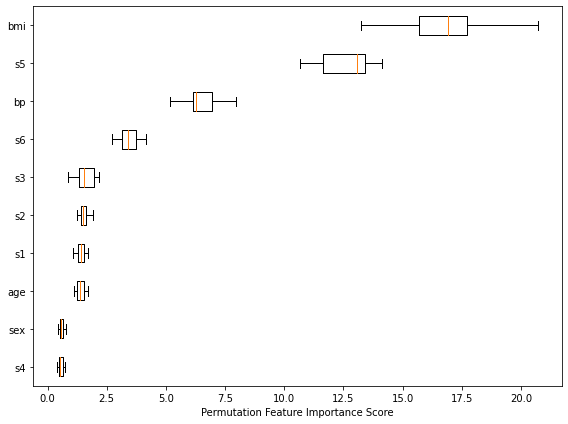

In [28]:
# use sklearn's permutation_importance function 
result = permutation_importance(model, X_train, y_train, scoring = 'neg_mean_absolute_error', n_repeats=20, random_state=42)
#result = permutation_importance(model, X_test, y_test, scoring = 'neg_mean_absolute_error', n_repeats=20, random_state=42)

perm_sorted_idx = result.importances_mean.argsort()

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_test.columns[perm_sorted_idx])
ax1.set_xlabel('Permutation Feature Importance Score')
fig.tight_layout()
plt.show()

## Advantages of this approach

* Easy to implement (several libraries, such us *sklearn* provide the algorithm)
* Fast to compute
* Model agnostic: can be used with *any* ML model
* Can be used for both regression and classification problems*

## Things to keep in mind

* Unclear whether the training or test set should be used
* Randomness in the shuffling can lead to **variation** in results
* Permutation Feature Importance does not deal with **correlated features** very well
    * Random shuffling may result in unrealistic samples, e.g. height of 2m and weight of 40kg
    * Correlated features may lose importance as their importance is "split" between them [nice example here](https://christophm.github.io/interpretable-ml-book/feature-importance.html)
* Permutation Feature Importance tells us how much a feature is important **for the model under consideration**, it is not a measure of the importance itself

# SHAP (SHapley Additive exPlanations)

- Concept that comes from game theory

- Setup: a coalition of players cooperates, and obtains a certain overall gain from that cooperation. Player contributions might be different. 
- How important is each player to the overall cooperation, and what payoff can he or she reasonably expect?

In [10]:
# <img src="Images/dirty_house.jpg" style="width: 500px; height: 200px;"/>



## Intuition from game theory

Alice (A) and Bob (B) are a married couple. They often fight over who is the one that makes the house dirty and they accuse each other.

At the end of every week, a person comes and cleans their house. The dirtier the house, the longer he stays (and gets paid)

They both travel for work and are often alone in the house for an entire week.

<img src="Images/dirty_house.jpg" style="width: 500px; height: 375px;"/>

<img src="Images/couple_fighting.jpg" style="width: 550px; height: 375px;"/>




$N$ = set of *players*: N = {A,B}
n = 2

$S$ is a *coalition* of players (or combination). The possible coalitions in this example are: S = {}, S = {A}, S = {B}, S = {A, B}
 
$f (S)$ is a function that tells us what are the *winnings* (price paid to the house cleaner) for each coalition. $f(\{\}) = 0$, $f({A}) = 20$, $f({B}) = 10$, $f({A, B}) = 50$

The **marginal contribution** of player A for a given coalition in which A is absent ($S \subseteq N \setminus {M}$) , is computed as: $f(S \cup {A}) - f(S)$
- $(f({A,B}) - f(B)) = 50-10 = 40$

The *Shapley value* for player A is the **weighted average** of all the marginal contributions $\\$
- $\varphi_{A}=\sum_{S \subseteq N \backslash\{A\}} \frac{|S| !(n-|S|-1) !}{n !}(f(S \cup\{A\})-f(S))$
- for a good explanation on the meaning of the weighting coefficients check this [blogpost](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30)


In our example:

$\varphi_{A} = 0.5 * (f(\{A\})-f(\{\}) + 0.5* (f({A,B}) - f(B))$ $= 0.5*20 + 0.5*40 = 30$ 

$\varphi_{B} = 0.5 * (f(\{B\})-f(\{\}) + 0.5* (f({A,B}) - f(A))$ $= 0.5*10 + 0.5*30 = 20$ 

## The machine learning setting

 - features = players
 - model output = *winnings* of the game

### House prices predictions: an example

* Suppose we have a model $y = f(x)$ for predicting the price $y$ of a house $x$
* The features are: number of bedrooms ($x_1$), floor area ($x_2$), and whether or not it has a garden ($x_3$)
* In our training data, the average price of all houses is £250,000
* Consider a new house that is about to go on the market: before we know anything about the house, our best guess at its value is £250,000
* Our prediction updates as we find out more information about the house:

We model the absence of a feature from a coalition by considering its mean value $E[x]$ across the training data.

For example, we know that 
* $f(x_1 = E[x_1], x_2 = E[x_2], x_3 = E[x_3]) = 250,000$
* $f(x_1 = 6, x_2 = E[x_2], x_3 = E[x_3]) = 310,000$
* $f(x_1 = 6, x_2 = 200, x_3 = E[x_3]) = 340,000$
* $f(x_1 = 6, x_2 = 200, x_3 = 0) = 285,000$

## Computing Marginal Contributions for Features: Example

* The **marginal contributions** for $x_1$ *for this house* are:
 * $f(x_1 = 6, x_2 = E[x_2], x_3=E[x_3]) - f(x_1=E[x_1], x_2=E[x_2], x_3=E[x_3])$  

 * $f(x_1=6, x_2=200, x_3=E[x_3]) - f(x_1=E[x_1], x_2=200, x_3=E[x_3])$  
 
 * $f(x_1=6, x_2=E[x_2], x_3=0) - f(x_1=E[x_1], x_2=E[x_2], x_3=0)$
 
 * $f(x_1=6, x_2=200, x_3=0) - f(x_1=E[x_1], x_2=200, x_3=0)$
* We can plug these into the Shapley Value formula to get the **local** Shapley value for this particular house
* Repeat this for all houses and take an average of the magnitude of the local Shapley values to get the **global** Shapley Value

## The SHAP algorithm


* Inputs: trained model $f(x)$ and test data $X \in \mathbb{R}^{n \times p}$. 
* Notation: let $S$ be the set of feature values that are included in the model (rather than substituting for the expected value) and $P$ is the set of all features
 
1. For each sample $i = 1,2,\ldots,n$:
    1. For each feature $j=1,2,\ldots,p$:
        1. Compute the weighted average of the marginal contributions to get the Shapley Value $\varphi_{ij}$ for sample $i$ and feature $j$:
            $$\varphi_{ij}=\sum_{S \subseteq P \backslash\{x_{ij}\}} \frac{|S| !(p-|S|-1) !}{p !}(f(S \cup\{x_{ij}\})-f(S))$$
    2. The Shapley Values $\{\varphi_{i1}, \varphi_{i2}, \ldots, \varphi_{ip}\}$ give the **local SHAP explanation** for sample $i$ 
2. To compute the **global SHAP explanation**, for each feature $j=1,2,\ldots,p$:
    1. Compute the average of the magnitude of the local Shapley Values $\varphi_j = \frac{1}{n}\sum_{i=1}^n |\varphi_{ij}|$ 

In [29]:
# create the shap explainer
shap_explainer = shap.TreeExplainer(model, X_train) # choose TreeExplainer because we have a tree based model (random forest)
shap_values = shap_explainer.shap_values(X_test) # compute shap values on test set
base_value = shap_explainer.expected_value # gives the base value (expected value for outcome - equivalent to the expected probability of class 1 for binary classification)

In [32]:
# this code would not render into the slides due to being interactive, but this code generated the image in the slides
# shap.initjs() # to visualise the shap plots
# shap.force_plot(base_value, shap_values[0,:], X_test.iloc[0,:])

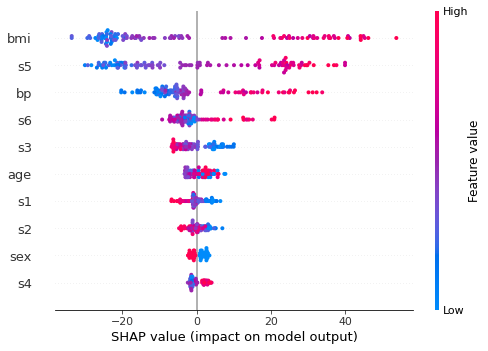

In [14]:
shap.summary_plot(shap_values, X_test)

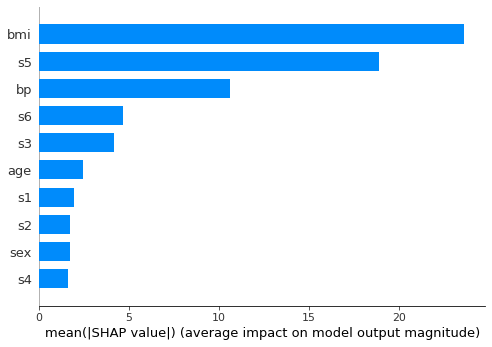

In [15]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

"Be careful to interpret the Shapley value correctly: The Shapley value is the average contribution of a feature value to the prediction in different coalitions. The Shapley value is NOT the difference in prediction when we would remove the feature from the model."

## Summary

In this notebook we covered the following:

* Motivating example of a black-box classifier on North Carolina State University diabetes Dataset
* Permutation Feature Importance method for generating global explanations
    * Intuition
    * Limitations
* SHAP (SHapley Additive exPlanations) for generating global (and local) explanations:
    * Shapley Values
    * Applying Shapley Values to feature importance